In [1]:
import os
import sys

from transformers import AutoModel, AutoTokenizer
import torch
from torch import nn
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb

from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, Dataset

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('GPU Using:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU Using: NVIDIA GeForce GTX 1070


In [3]:
train_aivivn_2019 = pd.read_csv('./data/aivivn-2019/train.csv')
test_aivivn_2019 = pd.read_csv('./data/aivivn-2019/test.csv')

In [4]:
train_data = train_aivivn_2019.sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

In [6]:
%cd /home/trild/workspace/finetune/

/home/trild/workspace/finetune


In [7]:
import py_vncorenlp
# Automatically download VnCoreNLP components from the original repository
# and save them in some local machine folder
# py_vncorenlp.download_model(save_dir='/home/trild/workspace/finetune/')

# Load the word and sentence segmentation component
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/home/trild/workspace/finetune')
# model = py_vncorenlp.VnCoreNLP(save_dir='/home/trild/workspace/finetune')

2025-01-14 08:27:18 INFO  WordSegmenter:24 - Loading Word Segmentation model


In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, rdrsegmenter):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.rdrsegmenter = rdrsegmenter
        self.text = dataframe.comment
        self.targets = dataframe.label
    
    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = self.text.iloc[idx]
        target = self.targets.iloc[idx]

        segmented_text = self.rdrsegmenter.word_segment(text)
        segmented_text = ' '.join(segmented_text)

        encoding = self.tokenizer(segmented_text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        encoding['input_ids'] = encoding['input_ids'].squeeze()
        encoding['attention_mask'] = encoding['attention_mask'].squeeze()

        return {
            'text': segmented_text,
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'target': torch.tensor(target, dtype=torch.long)
        }



In [9]:
def create_dataloader(dataframe, tokenizer, rdrsegmenter, batch_size):
    dataset = CustomDataset(dataframe, tokenizer, rdrsegmenter)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

In [10]:
import torch
import torch.nn as nn

class PhoBERTv2(nn.Module):
    def __init__(self, model, num_classes):
        super(PhoBERTv2, self).__init__()
        self.model = model
        self.mlp = nn.Sequential(
            nn.Linear(768*5, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, num_classes)
        )
        self.dropout = nn.Dropout(0.2)  # Reduced dropout

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states
        last_hidden_states = hidden_states[-5:]
        cls_embeddings = torch.cat([state[:, 0, :] for state in last_hidden_states], dim=1)
        cls_embeddings = self.dropout(cls_embeddings)
        logits = self.mlp(cls_embeddings)
        return logits


In [12]:
model = AutoModel.from_pretrained("vinai/phobert-base-v2", output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [13]:
phobertv2 = PhoBERTv2(model, num_classes=3)
phobertv2.to(device)

def train(model, train_dataloader, optimizer, criterion, num_epochs, accumulation_steps, device):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
        for i, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['target'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            loss = loss / accumulation_steps
            loss.backward()
            
            total_loss += loss.item()
            
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            # Cập nhật thanh tiến trình
            progress_bar.set_postfix({'loss': f"{total_loss/(i+1):.4f}"})
        
        # In kết quả sau mỗi epoch và log với wandb
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


batch_size = 32
num_epochs = 5
accumulation_steps = 5
learning_rate = 3e-5

optimizer = torch.optim.AdamW(phobertv2.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_dataloader = create_dataloader(train_data, tokenizer, rdrsegmenter, batch_size)
train(phobertv2, train_dataloader, optimizer, criterion, num_epochs, accumulation_steps, device)

Epoch 1/5:   0%|          | 0/403 [00:00<?, ?it/s]

Epoch 1/5: 100%|██████████| 403/403 [07:21<00:00,  1.09s/it, loss=0.1218]


Epoch 1/5, Loss: 0.1218


Epoch 2/5: 100%|██████████| 403/403 [06:21<00:00,  1.06it/s, loss=0.0448]


Epoch 2/5, Loss: 0.0448


Epoch 3/5: 100%|██████████| 403/403 [05:44<00:00,  1.17it/s, loss=0.0339]


Epoch 3/5, Loss: 0.0339


Epoch 4/5: 100%|██████████| 403/403 [05:40<00:00,  1.18it/s, loss=0.0290]


Epoch 4/5, Loss: 0.0290


Epoch 5/5: 100%|██████████| 403/403 [05:42<00:00,  1.18it/s, loss=0.0225]

Epoch 5/5, Loss: 0.0225


In [ ]:
def inference(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for data in dataloader:
            ids = data['input_ids'].to(device)
            mask = data['attention_mask'].to(device)
            targets = data['target'].to(device)

            outputs = model(ids, mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            true_labels.extend(targets.cpu().tolist())
    
    return predictions, true_labels

In [14]:
def test_report(model, dataloader, device):
    # Thực hiện inference
    predictions, true_labels = inference(model, dataloader, device)

    # Tạo confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Vẽ heatmap cho confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # In ra classification report (bao gồm precision, recall, f1-score)
    report = classification_report(true_labels, predictions, digits=4)
    print("Classification Report:")
    print(report)

In [15]:
test_aivivn_2019_dataloader = create_dataloader(test_aivivn_2019, tokenizer, rdrsegmenter, batch_size)

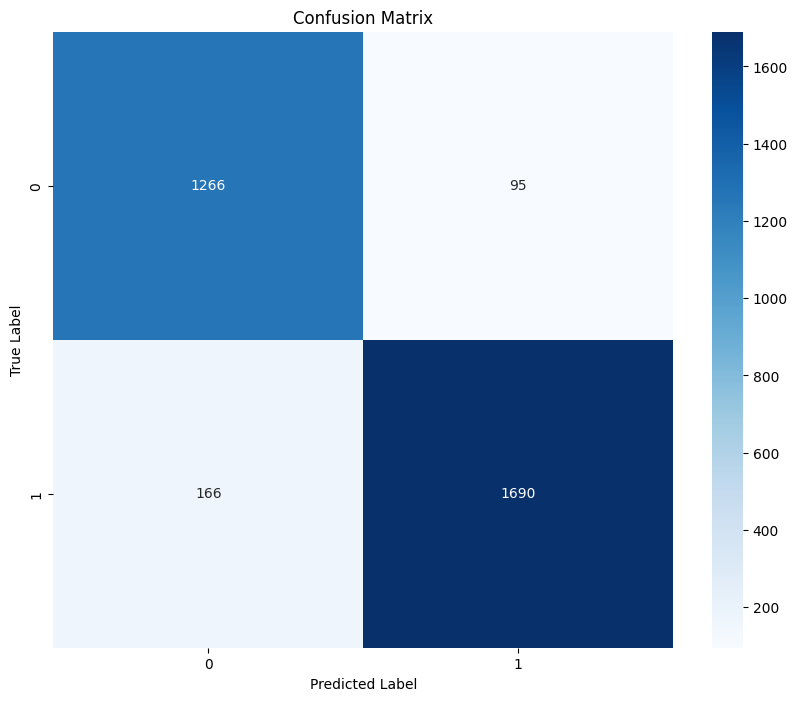

Classification Report:
              precision    recall  f1-score   support

           0     0.8841    0.9302    0.9066      1361
           1     0.9468    0.9106    0.9283      1856

    accuracy                         0.9189      3217
   macro avg     0.9154    0.9204    0.9174      3217
weighted avg     0.9203    0.9189    0.9191      3217



In [16]:
test_report(phobertv2, test_aivivn_2019_dataloader, device)

In [18]:
# Remove DataParallel wrapper and access the original model
if isinstance(phobertv2, nn.DataParallel):
    phobertv2 = phobertv2.module
#Save model
torch.save(phobertv2.state_dict(), "pretrained/phobertv2_sentiment_analysis.pth")

In [ ]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("vinai/phobert-base-v2", output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
model.to(device)